# Introduction

In machine learning and predictive modeling problems, many common classification datasets have relatively balanced class distribution. In fact, many problems in the broadly understood business area and related data are unbalanced. Problems of detecting fraud, machine failure, or predicting bankruptcy of a company are phenomena characteristic of a situation where one class defining a given observation occurs much less frequently than the other and is therefore much more valuable in terms of information provided. Moreover, for imbalanced data very often standard measures of model performance evaluation do not work as intended.

In this analysis, data mining methods (EDA) were used, for predictive purposes, machine learning techniques supervised with the use of selected classification models were applied, taking into account a set of methods improving the prediction of unbalanced data and optimization of hyperparameters.

The *Default of credit card clients* dataset obtained from the *UCI Machine Learning Repository* platform was used to analyze the problem, containing data on credit card customers in Taiwan, classified by insolvency.

The main objective of this project was to demonstrate comprehensive supervised machine learning model development process, focusing on imbalanced data. The key steps included are Exploratory Data Analyis, Model Development and Hyperparameter optimization.

Dataset used is *Default of credit card clients* downloaded from UCI Machine Learning repository.

# Libraries

## Install libraries

In [1]:
#%pip install pingouin ##for Google Colab

## Import libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

In [4]:
### Necessary libraries
import numpy as np
import pandas as pd
import scipy
import pingouin as pg
from tqdm.autonotebook import tqdm

### Data visulaization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

### Other libraries
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import clone
from sklearn import set_config
import imblearn as imb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
set_config(display="diagram")

### Model libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
xgb.set_config(verbosity=0)

#%matplotlib inline
#plt.rcParams.update(plt.rcParamsDefault)

# Dataset

## Dataset import

In [5]:
# from google.colab import files
# uploaded = files.upload()

In [6]:
filepath = 'default of credit card clients.csv'

df = pd.read_csv(filepath, index_col=0)

In [7]:
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Dataset description

Based on the information posted on the UCI Machine Learning Repository platform, the data was originally used for the purposes of the article: *The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients*, by I-Cheng Yeh and Che-hui Lien. The characteristics of the explanatory variables included in the data set are as follows:

* X1: Loan amount granted in Taiwan dollar,
* X2: Gender, where: 1 is male, 2 is female,
* X3: Education, where: 1 is a post-graduate school (university); 2 is a university, 3 is a secondary school, and 4 the rest,
* X4: Marital status, where: 1 is married, 2 is single / unmarried, 3 others,
* X5: Age
* X6 - X11: Card maturity history. The maturity status from April to September, where: X6 is the September maturity status, X7 is the August maturity status, etc. up to X11 the April maturity status. As part of the measurement of the repayment status, the following values were adopted: -1 payment made on time, 1 repayment delayed one month, 2 repayment delayed by two months, etc., up to 9, where repayment was delayed for nine months or more,
* X12-X17: Monthly Taiwan dollar amount, where X12 is the September statement, X13 is the August statement, etc., up to X17 the April statement.
* X18-X23: Amount repaid (in Taiwan dollar), where X18 is the amount paid in September, X19 is the amount paid in August, and so on, up to X23 is the amount paid in April.

The last feature in the data set is a target variable, where 0 means that the customer repays the required loan amount in the next month, and 1 means that there is no such credit.

After reviewing the above data characteristics and obtaining preliminary information about the set, the following facts were found, determining the next steps in data preparation:

* no empty elements in the data set,
* the existence of categorical and numerical features in the data set, and
* the presence of inordered and ordered categorical features

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

## Data pre-processing

In order to streamline the process of referencing variables, preprocessing of feature names in the data set was performed:

In [9]:
#Rename variables
df.columns = df.columns.str.lower().str.replace('default payment next month', 'default')

Checking unique values of variables X2-X5

In [10]:
df['sex'].value_counts(sort=True)

2    18112
1    11888
Name: sex, dtype: int64

In [11]:
df['education'].value_counts(sort=True)

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: education, dtype: int64

In [12]:
df['marriage'].value_counts()

2    15964
1    13659
3      323
0       54
Name: marriage, dtype: int64

Variables: **'education'** and **'marriage'** seem to include observations outside of range specified in data description:

In [13]:
df[['sex','education','marriage']].apply(pd.Series.nunique)

sex          2
education    7
marriage     4
dtype: int64

In order to further work with the data, categorical variables have been transformed using Dictionary object. Values outside the range indicated in the data set description have been reclassified to the 'others' category.

Observed values for variables from **pay_0** to **pay_6** not specified in the dataset characteristics were not transformed due to the potential added value for prediction.

In [14]:
sex_dict = {
    1: 'male',
    2: 'female',
    }

education_dict = {
    0: 'others',  #Not explained
    1: 'graduate school',
    2: 'university',
    3: 'high school',
    4: 'others',
    5: 'others',  #Not explained
    6: 'others'   #Not explained
    }

marriage_dict = {
    0: 'others',  #Not explained
    1: 'married',
    2: 'single',
    3: 'others',
    }

df['sex'] = df['sex'].map(sex_dict)
df['education'] = df['education'].map(education_dict)
df['marriage'] = df['marriage'].map(marriage_dict)


Then the data set was divided into the part containing the independent variables `X` and dependent variable` y`

After analyzing the distribution of values taken by the target variable, it turns out that we are dealing with an unbalanced set, which affects further stages of this study.

In [15]:
X, y = df.drop(columns=["default"]), df.default == 1
y.value_counts(normalize=True)

False    0.7788
True     0.2212
Name: default, dtype: float64

# Exploratory Data Analysis

## Initial statistics

Below `describe()` method of pandas DataFrame object was used to extract basic measures of central tendency and dispersion: mean, standard deviation, minumum and maximum values, and relevant quantiles of the dataset

In [16]:
df.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
limit_bal,30000.0,167484.32,129747.66,10000.0,50000.00,140000.0,240000.00,1000000.0
age,30000.0,35.49,9.22,21.0,28.00,34.0,41.00,79.0
pay_0,30000.0,-0.02,1.12,-2.0,-1.00,0.0,0.00,8.0
pay_2,30000.0,-0.13,1.20,-2.0,-1.00,0.0,0.00,8.0
pay_3,30000.0,-0.17,1.20,-2.0,-1.00,0.0,0.00,8.0
pay_4,30000.0,-0.22,1.17,-2.0,-1.00,0.0,0.00,8.0
pay_5,30000.0,-0.27,1.13,-2.0,-1.00,0.0,0.00,8.0
pay_6,30000.0,-0.29,1.15,-2.0,-1.00,0.0,0.00,8.0
bill_amt1,30000.0,51223.33,73635.86,-165580.0,3558.75,22381.5,67091.00,964511.0
bill_amt2,30000.0,49179.08,71173.77,-69777.0,2984.75,21200.0,64006.25,983931.0


## Data visualization

The probability distribution of customer age is presented below, in the form of the distribution density plot on the left and the distribution function on the right, broken down by sex.

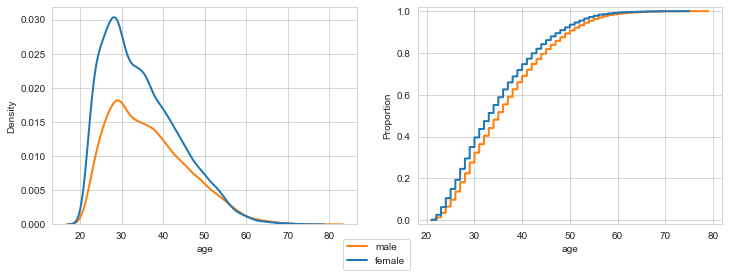

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
         
sns.kdeplot(ax=axes[0], data=df, x='age', hue='sex',
            linewidth=2, ls='-', legend=False)
sns.ecdfplot(ax=axes[1], data=df, x='age', hue='sex',
             linewidth=2, ls='-', legend=False).set_ylim(-0.02,1.02)
fig.legend(['male', 'female'], loc = 'lower center', bbox_to_anchor=(0.5, -0.05), ncol=1)
plt.show()

The following charts presents the ratio of of default credit cards in the next month, broken down by sex, marital status and education. It seems like, men tend to default more often than women.

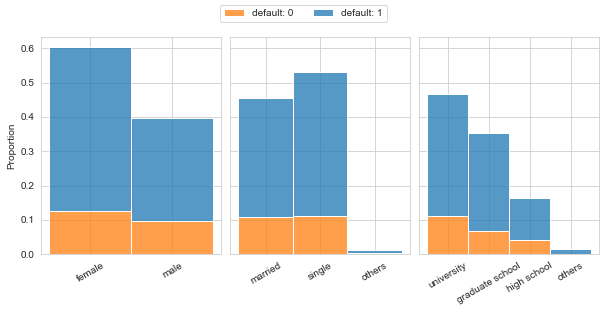

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
plt.subplots_adjust(wspace=0.05)

x_data = {axes[0]:'sex', axes[1]:'marriage', axes[2]:'education'}

for ax in axes:
    sns.histplot(ax=ax, data=df, x=x_data.get(ax), hue='default', 
             multiple='stack', stat='proportion', legend=False)
    ax.tick_params(axis='x', rotation=30)
    ax.xaxis.set_label_text('')
    
fig.legend(['default: 0', 'default: 1'], loc = 'upper center', ncol=2)

plt.show()

Then, specific numeric variables have been presented: **X0 limit_bal**, being the credit card limit balance of an idividual obervation, **X12 bill_amt1** bill_amt as amount to pay for the last month, as well as **X18 pay_amt1**, being the value of the last payment.

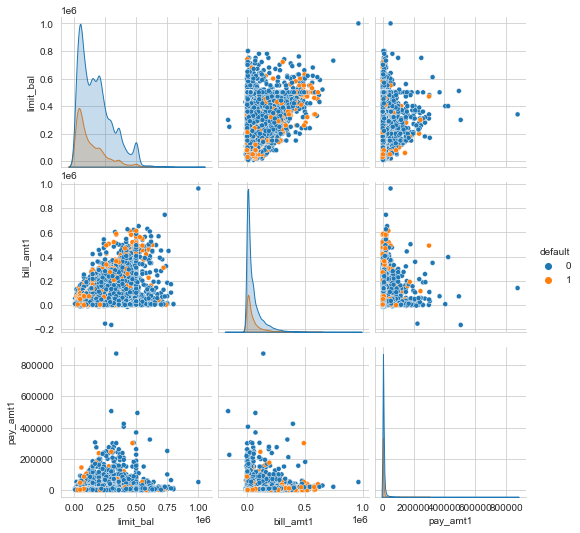

In [19]:
sns.pairplot(df, x_vars=["limit_bal", "bill_amt1",'pay_amt1'],
    y_vars=["limit_bal", "bill_amt1",'pay_amt1'], hue='default', 
             plot_kws={'s': 25})
plt.show()

To illustrate the correlation between individual features, a correlation matrix was created. As we can see, the most positively correlated features are the ones related to the status of the payment, as well as monthly statement values. However, no features with a strongly negative correlation were observed.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


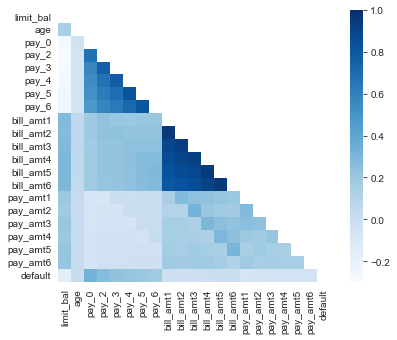

In [20]:
corr_mat = df.rename(columns={'default_payment_next_month': 'default'}).corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(corr_mat, cmap='Blues', mask=mask, vmax=1, square=True)

# Data preparation for modeling

## Data split

The first step of predictive modeling using supervised learning techniques will be split of the data. Primary approach is to divide our data into training dataset, used to train our model and into test dataset, used for performance evaluation of the model. Knowing we are working with imbalance data set, the split was performed in a way to preserve the actual target variable distribution (78% of negative observations, 22% positive observations).

As the process of optimizing the effectiveness of selected models will consist of a series of consecutive stages, the ongoing assessment of the impact of the optimization process will also be important. Due to the fact that our test data should not be used in the classifier training process, the above-mentioned split has been extended to validation data, in the following proportion:

*   Training data 80%
*   Validation data 10%
*   Test data 10%



In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=34, stratify=y_test)

print("Train: 0:", len(y_train) - sum(y_train), "1: ", sum(y_train))
print("Val:   0:", len(y_val) - sum(y_val), "1: ", sum(y_val))
print("Test:  0:", len(y_test) - sum(y_test), "1: ", sum(y_test))

Train: 0: 18691 1:  5309
Val:   0: 2337 1:  663
Test:  0: 2336 1:  664


## Data transforming

Our dataset contains different types of features. In order to work with classifier objects from **scikit-learn** library, it is necessary to transform the data, with the below tools:

*   StandardScaler - to standardize numeric features
*   OneHotEncoder - to encode categorical features
*   OrdinalEncoder - to encode categorical features, preserving their hierarchy


Below Lists were created, with relevant features assigned:

In [22]:
num_features = ['limit_bal','age', 'pay_0', 'pay_2','pay_3', 'pay_4', 'pay_5', 
                'pay_6','bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 
                'bill_amt5', 'bill_amt6', 'pay_amt1','pay_amt2', 'pay_amt3', 
                'pay_amt4', 'pay_amt5', 'pay_amt6',]      

cat_features = ['sex','marriage']

ord_features = ['education']

Then, our transforming objects were created, including specific order for *education* feature.

In [23]:
numerical_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(sparse=False)

education_hierarchy = [["others", "high school", "university", "graduate school"]]

ordinal_transformer = OrdinalEncoder(categories=education_hierarchy)

The above standardizing and endcoding objects were passed on to newly created `ColumnTransformer`. This allow us to effectively manage our predictive modling process later on.

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
                  ('numerical',numerical_transformer, num_features),
                  ('categorical',categorical_transformer, cat_features),
                  ('ord_categorical',ordinal_transformer, ord_features)
    ])

## Pipeline

In order to streamline the modeling process a **Pipeline** object was created.

As our our main goal to handle imbalanced data is applying **under/oversampling** techniques, a `Pipeline` class object from the **imbalanced-learn** library will be used. This way we can include the mentioned solution in the entire process.

The previously created `preprocessor` object, which will be used to transform the data, was applied as the first step in the `pipe` object.

In [25]:
pipe = imb.pipeline.Pipeline(steps=[('preprocessor',preprocessor)])

The scheme of an object constructed in this way looks like this:

In [26]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['limit_bal', 'age', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
                                                   'pay_amt3', 'pay_amt4',
                                                   'pay_amt5', 'pay_amt6']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse=False),
                                                  ['sex', 'marriage']),
                                                 ('ord_categorical',
                                                  OrdinalEncoder(categories=[['others',
                                                                              'high '
                                                                              'school',
                                                                              'university',
                                                                              'graduate '
                                                                              'school']]),
                                                  ['education'])]))])

# Model preparation

## Model description

There are many types of supervised machine learning models. For the purposes of the analysis, several types of classification models were selected:

**DecisionTree**

Basic and easy to interpret method of classification which consists of split data into subsets. Each subset is split per the value of the selected feature between the values higher and lower than the observed value (criterion). The split criterion is determined in order to minimize the heterogeneity of the results in each subset.

**K-Nearest Neighbours**

The idea of the algorithm is to classify the observations to a selected class on the basis of similarity to the number K of the closest remaining observations. Similarity is determined by a Euclidean distance measure, a *Manhattan* or other metrics.

**NaiveBayes**

The model is based on probability of an observed feature for a given result to estimate the probability of observation a given class for a given set of explanatory variables. In the naive classifier, it is important to assume that the selected explanatory variable is independent of all other explanatory variables.

**RandomForest**

An aggregated model based on combining the results of less complex decision tree models. It uses *bagging*, i.e. bootstrap aggregation (sampling with return from a data set) and model averaging. This model takes into account the significance of the variable and is specified by a set of hyperparameters that can be optimized

**XGBoost**

Another aggregated model, which is a stochastic implementation of gradient boosting, i.e. a method of error reduction in subsequent model predictions, supported by observation & feature sampling at each subsequent iteration. A computationally efficient model, with large number of hyperparameters for optimization

**LightGBM**

Similarly to XGBoost model, it is also based on gradient boosting, but unlike most models based on decision trees, new nodes are not created based on a tree level, but on individual "leaves" in separate nodes and and the highest loss reduction associated with, which significantly affects the performance of a model while maintaining the accuracy of prediction, however, it may potentially show a greater tendency to overfit.

As part of improving the reference to individual machine learning models, a `models` dictionary was created, where we applied individual classifiers

In [27]:
models = {
    "DecisionTree": DecisionTreeClassifier(),
     "KNN": KNeighborsClassifier(),
     "LightGBM": lgb.LGBMClassifier(),     
     "NaiveBayes": GaussianNB(),
     "RandomForest": RandomForestClassifier(),
     "XGBoost": xgb.XGBClassifier(use_label_encoder=False)
    }

## Model evaluation criteria

The basic classification models' evaluation metric is an accuracy.
<br/><br/>
\begin{align}
        accuracy = \frac{TP+TN} {TP+TN+FP+FN}
    \end{align}

where: 

*   TP - True Positives
*   TN - True Negatives
*   FP - False Positives
*   FN - False Negatives
<br/><br/>

Since the distribution of classes in the analyzed data set is unbalanced, the above-mentioned evaluation metric may be insufficient for a reliable assessment. This is due to the fact that the prediction of a small class is also much more important from the problem perspective. In addition, taking into account the so-called *the validity paradox*, a potential model classifying all observations into the majority class could demonstrate a relatively high validity rating. Therefore, the harmonic precision-recall mean F1 will be used as a model evaluation metric, in the form:


<br/><br/>
\begin{align}
       F1 = \frac{TP} {TP + 0.5(FP+FN)}  
    \end{align}
<br/><br/>



In [28]:
f1_scoring = make_scorer(f1_score)

In order to evaluate the effectiveness of the model prediction, k-fold cross-validation will be used, which is randomly shuffling a data set and dividing the set into k-groups. Then, within each group, a set of test and training data is separated. The model is trained solely on the training data and then evaluated based on the prediction of the test data and the relevant metric. The process carried out in this way on each of the groups allows a more reliable assessment of the model.

The k number of individual groups for cross-validation is determined:

In [29]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=34)

## Initial evaluation of baseline models 

The initial model evaluation is performed with **cross_val_score**. As part of a single iteration, the following steps are applied for each model:

1. Based on a copy of the previously designed initial pipeline, a model from the `models` dictionary has been added. This will allow the data to be transformed before fitting to the model.
2.      Using the **cross_val_score** object, the model was trained on training data within a predetermined **k-fold** value.
3.     The result of the model evaluation based on F1 was entered in the corresponding `model_results` dictionary

Dictionary with the cross-validation results will be passed to the newly created DataFrame for further analysis:


In [30]:
model_results = {}
for name, model in tqdm(models.items()):
    pipe_copy = clone(pipe)
    pipe_copy.steps.append(['classifier', model])
    cv_results = cross_val_score(pipe_copy, X_train, y_train, cv=skfold, 
                                 n_jobs=5, scoring=f1_scoring)
    model_results[name] = cv_results

model_results_df = pd.DataFrame(model_results)

  0%|          | 0/6 [00:00<?, ?it/s]

The results of the base models are as follows:

In [31]:
model_results_df.describe()

,DecisionTree,KNN,LightGBM,NaiveBayes,RandomForest,XGBoost
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.404077,0.431088,0.477637,0.468628,0.475340,0.469746
std,0.024762,0.021459,0.023549,0.016801,0.025636,0.028431
min,0.361242,0.401880,0.438964,0.442792,0.436975,0.425949
25%,0.384584,0.410286,0.460749,0.458265,0.459873,0.452575
50%,0.409067,0.437379,0.479630,0.471493,0.463779,0.472079
75%,0.421207,0.450219,0.495845,0.476608,0.499728,0.485973
max,0.436429,0.453820,0.507822,0.500334,0.511085,0.517200


In order to visualize and compare the results, the boxplot function from the **Seaborn** library was used.

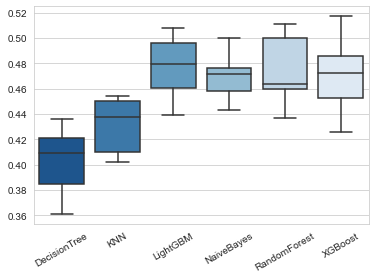

In [32]:
ax = sns.boxplot(data=model_results_df, palette="Blues_r")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

## Model evaluation sigificance

To test the significance of the results obtained by cross-validation, the null hypotheses H<sub>0</sub> will be tested with the following significance tests:

* Kruskal-Wallis H test, which will test the null hypothesis of the calculated median for each group within the population, and
* Two-tailed t-test that will allow you to test the significance of the difference in mean scores between each pair of models

Below we can see t test results, which was generated by the following function of the library **pingouin**.

In [33]:
model_results_pg = model_results_df.melt(var_name='model', 
                                                 value_name='result')

pg.kruskal(model_results_pg, dv='result', between='model').round(3)

,Source,ddof1,H,p-unc
Kruskal,model,5,34.33,0.0


In [34]:
pg.pairwise_ttests(model_results_pg, parametric=False, dv='result', 
                   between='model').round(3)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges
0,model,DecisionTree,KNN,False,False,23.0,two-sided,0.045,-1.117
1,model,DecisionTree,LightGBM,False,False,0.0,two-sided,0.000,-2.916
2,model,DecisionTree,NaiveBayes,False,False,0.0,two-sided,0.000,-2.922
3,model,DecisionTree,RandomForest,False,False,0.0,two-sided,0.000,-2.708
4,model,DecisionTree,XGBoost,False,False,2.0,two-sided,0.000,-2.359
5,model,KNN,LightGBM,False,False,7.0,two-sided,0.001,-1.979
6,model,KNN,NaiveBayes,False,False,8.0,two-sided,0.002,-1.866
7,model,KNN,RandomForest,False,False,5.0,two-sided,0.001,-1.793
8,model,KNN,XGBoost,False,False,14.0,two-sided,0.007,-1.470
9,model,LightGBM,NaiveBayes,False,False,62.0,two-sided,0.385,0.422


## Class balancing

After the obtaining intitial results of individual models, the following optimization activities were introduced.

The first step in optimizing the model, one of the methods of class balancing was designated, which may, to some extent, contribute to better training of the model and, consequently, to the overall improvement of the quality of prediction. Basic class balancing techniques include:

**Undersampling** where the observations for the major class are reduced. Reducing the number of observations has a positive effect on the performance of the model, reducting a portion of information that could potentially be obtained from rejected samples

**Oversampling**, where the number of observations for the minority class is increased using synthetically created samples, including the popular SMOTE algorithm that allows to generate new observations using the K-Nearest Neighbors algorithm.

For the purposes of the project, the Neighborhood Cleaning Rule (NCR) method was selected, which combines the Condensed Nearest Neighbor (CNN) technique and Edited Nearest Neighbors (ENN), which remove redundant and misclassified observations from the majority class at the same time. The implementation of the NCR algorithm from the **imbalanced-learn** library was applied. A `sampler` object created in this way was added to `pipe`.

In [35]:
sampler = imb.under_sampling.NeighbourhoodCleaningRule() #1

pipe = imb.pipeline.Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('sampler', sampler)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['limit_bal', 'age', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
                                                   'pay_amt3', 'pay_amt4',
                                                   'pay_amt5', 'pay_amt6']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse=False),
                                                  ['sex', 'marriage']),
                                                 ('ord_categorical',
                                                  OrdinalEncoder(categories=[['others',
                                                                              'high '
                                                                              'school',
                                                                              'university',
                                                                              'graduate '
                                                                              'school']]),
                                                  ['education'])])),
                ('sampler', NeighbourhoodCleaningRule())])

It is important to note that application of the above-mentioned resampling technique in the Pipeline, despite the noticeable reduction in the efficiency of the tools for cross-validation of selected models (compared to the use of training data with the already pre-applied undersampling technique), will, however, avoid potential data leakage, which could lead to get overly optimistic, better prediction results for the training set, but not necesserly means the same prediction effectiveness on the test set.

The `pipe` object prepared in this way is used to re-evaluate the models:

In [36]:
model_results_resamp = {}
for name, model in tqdm(models.items()):
    pipe_copy = clone(pipe)
    pipe_copy.steps.append(['classifier', model])
    cv_results_resamp = cross_val_score(pipe_copy, X_train, y_train, 
                                        cv=skfold, n_jobs=5, 
                                        scoring=f1_scoring)
    model_results_resamp[name] = cv_results_resamp

model_results_resamp_df = pd.DataFrame(model_results_resamp)

  0%|          | 0/6 [00:00<?, ?it/s]

In [37]:
model_results_resamp_df.describe()

,DecisionTree,KNN,LightGBM,NaiveBayes,RandomForest,XGBoost
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.462867,0.493651,0.543861,0.424549,0.541694,0.534441
std,0.010974,0.021862,0.022606,0.009990,0.020159,0.018178
min,0.447648,0.448220,0.504744,0.409614,0.512535,0.510166
25%,0.456569,0.484766,0.530067,0.419831,0.532591,0.522975
50%,0.457578,0.493414,0.548391,0.422627,0.542080,0.534094
75%,0.468995,0.510746,0.555922,0.430572,0.546097,0.545694
max,0.480811,0.519142,0.583630,0.444669,0.582960,0.569676


To present the effect of applying the class balancing approach, the box plot from the **Seaborn** library was used again. As we can see, the Neighborhood Cleaning Rule technique had a positive impact on the effectiveness of most models. The exception is the Naive Bayesian classifier, where the reduced number of observations for the majority class probably lowered the performance of this model.

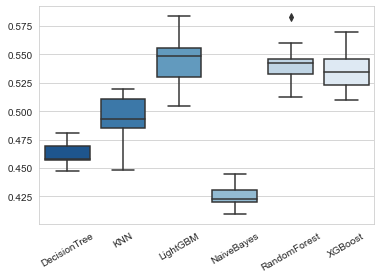

In [38]:
ax = sns.boxplot(data=model_results_resamp_df, palette="Blues_r")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

Again, the following tests were used: Kruskal-Wallis H and the two-tailed t-test from the **pingouin** library to test the significance of differences between models' performance:

In [39]:
model_results_resamp_pg = model_results_resamp_df.melt(var_name='model', 
                                                               value_name='result')
pg.kruskal(model_results_resamp_pg, dv='result', between='model').round(3)

,Source,ddof1,H,p-unc
Kruskal,model,5,48.976,0.0


In [40]:
pg.pairwise_ttests(model_results_resamp_pg, 
                   parametric=False, dv='result', between='model').round(3)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges
0,model,DecisionTree,KNN,False,False,11.0,two-sided,0.004,-1.704
1,model,DecisionTree,LightGBM,False,False,0.0,two-sided,0.000,-4.366
2,model,DecisionTree,NaiveBayes,False,False,100.0,two-sided,0.000,3.497
3,model,DecisionTree,RandomForest,False,False,0.0,two-sided,0.000,-4.652
4,model,DecisionTree,XGBoost,False,False,0.0,two-sided,0.000,-4.566
5,model,KNN,LightGBM,False,False,4.0,two-sided,0.001,-2.163
6,model,KNN,NaiveBayes,False,False,100.0,two-sided,0.000,3.894
7,model,KNN,RandomForest,False,False,3.0,two-sided,0.000,-2.188
8,model,KNN,XGBoost,False,False,5.0,two-sided,0.001,-1.943
9,model,LightGBM,NaiveBayes,False,False,100.0,two-sided,0.000,6.539


The p-value returned by both significance test functions indicates the probability that a score as extreme as that observed in the study may occur, taking into account the null hypothesis of the model. Therefore it was assumed that:

* the LightGBM, RandomForest and XGBoost models seem to perform better than the others and the alternative hypothesis H<sub>1</sub> has been accepted for them
* on the basis of our results, it cannot be concluded that any model in the group of LightGBM, RandomForest and XGBoost models is significantly better than the others

## Hyperparameters optimization - Grid Search

As a next step of models' performance improvement, is optimizing their hyperparameters. **Hyperparameters** are the configurable elements of the model that affect the model training process. The **Grid Search** technique will be used to initially improve the hyperparameters.

This technique is based on defining hyperparameter space, where each dimension of this space represents a given hyperparameter and each point in the space is a single possible configuration. As part of the Grid Search optimization procedure, all points in the space are searched in order to find the configuration of elements that has the best impact on improving the predictive efficiency of the model

From the group of previously selected models, three top classifiers were selected: LightGBM, RandomForest, XGBoost, and additionally - KNN model, in order to investigate how the optimization will affect a potentially less effective model.

In [41]:
models = {
     "KNN": KNeighborsClassifier(),
     "LightGBM": lgb.LGBMClassifier(),     
     "RandomForest": RandomForestClassifier(),
     "XGBoost": xgb.XGBClassifier(use_label_encoder=False, )
    }

Due to the time efficiency of the algorithm, the initial optimization was limited to the selection of three hyperparaments per model. The default values for each model were used as a benchmark in determining the scope of the hyperparameter space, according to the documentation of the **scikit-learn, LightGBM** and **XGBoost** libraries.

A dictionary was created with a pair: model name-set of parameters:

In [42]:
param_grids = {
  
    'KNN': {'classifier__n_neighbors': range(2, 8, 1),
              'classifier__algorithm': ['ball_tree','kd_tree', 'brute'],
              'classifier__metric': ('minkowski', 'chebyshev', 'euclidean', 'manhattan'),
           }, 
    
    'LightGBM': {
                   'classifier__max_depth': np.arange(2, 12, 1, dtype=int),
                   'classifier__colsample_bytree': np.linspace(0.3, 1, 5),
                   'classifier__num_leaves': [15, 31, 63, 127]
                  },
    
    'XGBoost': {  'classifier__colsample_bytree': np.linspace(0.3, 1, 5),      
                  'classifier__max_depth': np.arange(2, 12, 1, dtype=int),
                  'classifier__min_child_weight': np.arange(1, 3, 1, dtype=int),
           }, 
    
    'RandomForest' : {
                 'classifier__max_depth': np.arange(5, 15, 1, dtype=int), 
                 'classifier__min_samples_leaf': [1, 2, 5, 10, 15, 20],
                 'classifier__min_samples_split': [2, 5, 10] 
            }
          }

The process of searching for the best parameters was carried out using an object created from the **GridSearchCV** class from the **scikit-learn** library and then the obtained results, along with the best combination of hypermarameters obtained, were transferred to the results dictionary

In [43]:
search_data = {d: [] for d in ['model','best_score','best_params']}

for name, model in tqdm(models.items()):
    pipe_copy = clone(pipe)
    pipe_copy.steps.append(['classifier', model])
    search = GridSearchCV(pipe_copy, param_grids.get(name), 
                               scoring=f1_scoring, cv=skfold, 
                               n_jobs=-1, verbose=1) 
    search.fit(X_train, y_train)
    
    search_data['model'].append(name)
    search_data['best_score'].append(search.best_score_)
    search_data['best_params'].append(search.best_params_)

search_data_df = pd.DataFrame(search_data)

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


For the purposes of further processing of the results, the names of the keys in the dictionary have been modified:

In [44]:
search_data_df = pd.DataFrame(search_data).set_index(['model'])

updated_params = []
for d in search_data_df.best_params:
    updated_params.append({ k.replace('classifier__', ''): v for k, v in d.items() })

search_data_df.drop(columns='best_params')
search_data_df['best_params'] = updated_params

search_data_df

,best_score,best_params
model,,
KNN,0.508034,"{'algorithm': 'brute', 'metric': 'chebyshev', ..."
LightGBM,0.548642,"{'colsample_bytree': 0.825, 'max_depth': 9, 'n..."
RandomForest,0.546393,"{'max_depth': 14, 'min_samples_leaf': 10, 'min..."
XGBoost,0.547988,"{'colsample_bytree': 1.0, 'max_depth': 3, 'min..."


The best set hyperparameters for each of the selected models were used for the standard evaluation of models' performance:

In [45]:
model_results_optim = {}
for name, model in tqdm(models.items()):
    
    params = search_data_df.best_params.loc[str(name)]
    model.set_params(**params)
    
    pipe_copy = clone(pipe)
    pipe_copy.steps.append(['classifier', model])
    cv_results_resamp = cross_val_score(pipe_copy, X_train, y_train, 
                                        cv=skfold, n_jobs=5, 
                                        scoring=f1_scoring)
    model_results_optim[name] = cv_results_resamp

model_results_optim_df = pd.DataFrame(model_results_optim)

  0%|          | 0/4 [00:00<?, ?it/s]

In [46]:
model_results_optim_df.describe()

,KNN,LightGBM,RandomForest,XGBoost
count,10.000000,10.000000,10.000000,10.000000
mean,0.508034,0.548642,0.544844,0.547988
std,0.024035,0.021581,0.024405,0.021841
min,0.460208,0.513208,0.512077,0.516008
25%,0.498725,0.539508,0.527080,0.534693
50%,0.507442,0.546684,0.545215,0.548041
75%,0.523476,0.562143,0.558607,0.561759
max,0.542881,0.586425,0.588889,0.583559


The results of individual models were visualized:

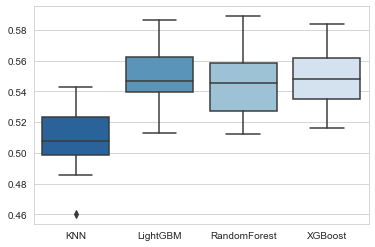

In [47]:
ax = sns.boxplot(data=model_results_optim_df, palette="Blues_r")
plt.show()

And then a significance test was performed:

In [48]:
model_results_optim_normalized = model_results_optim_df.melt(var_name='model', 
                                                               value_name='result')
pg.kruskal(model_results_optim_normalized, dv='result', between='model').round(4)

,Source,ddof1,H,p-unc
Kruskal,model,3,14.4849,0.0023


In [49]:
pg.pairwise_ttests(model_results_optim_normalized, 
                   parametric=False, dv='result', between='model').round(3)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges
0,model,KNN,LightGBM,False,False,8.0,two-sided,0.002,-1.703
1,model,KNN,RandomForest,False,False,12.0,two-sided,0.005,-1.456
2,model,KNN,XGBoost,False,False,9.0,two-sided,0.002,-1.666
3,model,LightGBM,RandomForest,False,False,55.0,two-sided,0.734,0.158
4,model,LightGBM,XGBoost,False,False,48.0,two-sided,0.910,0.029
5,model,RandomForest,XGBoost,False,False,44.0,two-sided,0.678,-0.130


The performed initial optimization of hyperparameters, despite the improvement of the model results, did not help in finding the best model. The decision was made to further optimize the XGBoost model, although both the LightGBM and RandomForest models seem to show similar potential for prediction purposes.

# Final model recomendation and further optimization

XGBoost model was selected. The results from the **Grid Search** process were used as basic parameters. The model was placed in the temporarily created Pipeline:

In [50]:
best_params_gs = search_data_df.loc['XGBoost'].best_params
selected_model = xgb.XGBClassifier(use_label_encoder=False, 
                                   **best_params_gs, 
                                   verbosity=0, 
                                  # learning_rate=0.05,
                                   #n_estimators=500
                                  )

pipe_copy = clone(pipe)
pipe_copy.steps.append(['classifier', selected_model])
pipe_copy.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['limit_bal', 'age', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
                                                   'pay_amt3', 'pay_amt4',
                                                   'pay_amt5', 'pay_amt6']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse=False),
                                                  ['sex'...
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=3, min_child_weight=2, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=0)]])

## Detailed model evaluation

In order to more precisely evaluate the model and its subsequent optimization steps, the `model_performance_check` function was created, which will allow for a detailed presentation of the evaluation of the model's effectiveness at each stage.

In [51]:
def model_performance_check(model, X_test, y_test):
    
    #Prediction
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    conf_matix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matix.ravel()

    pos_probs = y_pred_prob[:, 1]

    fpr, tpr, _ = roc_curve(y_test, pos_probs) 
    precision, recall, _ = precision_recall_curve(y_test, pos_probs)
        
    if not model.__class__.__name__ == 'Pipeline':
        model_name = model.__class__.__name__
    else:
        model_name = model.steps[-1][1].__class__.__name__
    
    #Plots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'{model_name}', fontsize=16)

    #Confusion matrix
    labels = ['Negative', 'Positive']
    annot_names = ['TN','FP','FN','TP']
    annot_count = ['{0:0.0f}'.format(v) for v in conf_matix.flatten()]
    annot_pct = ['{0:.2%}'.format(v) for v in conf_matix.flatten()/np.sum(conf_matix)]
    annot = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(annot_names, annot_count, annot_pct)]
    annot = np.asarray(annot).reshape(2,2)

    sns.heatmap(conf_matix, annot=annot, fmt="", linewidths=.5, 
              cmap='Blues_r', robust=True, square=True, cbar=False, ax=ax[0],
              annot_kws={"ha": 'center', "va": 'center', 'size':12})

    ax[0].set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix')
    ax[0].xaxis.set_ticklabels(labels)
    ax[0].yaxis.set_ticklabels(labels)

    #ROC Curve
    ax[1].plot([0, 1], [0, 1], linestyle='--', label='Random')  
    ax[1].plot(fpr, tpr, marker='.', label='model')
    ax[1].grid(visible=True, linestyle="--", color='gray',linewidth=0.5)
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC Curve')

    #PR Curve
    no_skill = len(y_test[y_test==1]) / len(y_test)
    ax[2].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    ax[2].plot(recall, precision, label='Trained model')
    ax[2].grid(visible=True, linestyle="--", color='gray',linewidth=0.5)
    ax[2].set_xlabel('Recall')
    ax[2].set_ylabel('Precision')
    ax[2].set_title('P-R Curve')

    handles, labels = ax[2].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)
 
    roc_auc = roc_auc_score(y_test, pos_probs)
    auc_score = auc(recall, precision)
    
    plt.show()

    print(f'F1 Score: {f1_score(y_test, y_pred):.4f}')    
    print(f'Recall: {recall_score(y_test, y_pred):.4f}')    
    print(f'Precision: {precision_score(y_test, y_pred):.4f}')    
    print(f'Specificity: {(tn / (tn + fp)):.4f}')    
    print(f'ROC AUC Score: {roc_auc}')
    print(f'P-R AUC Score: {auc_score}')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


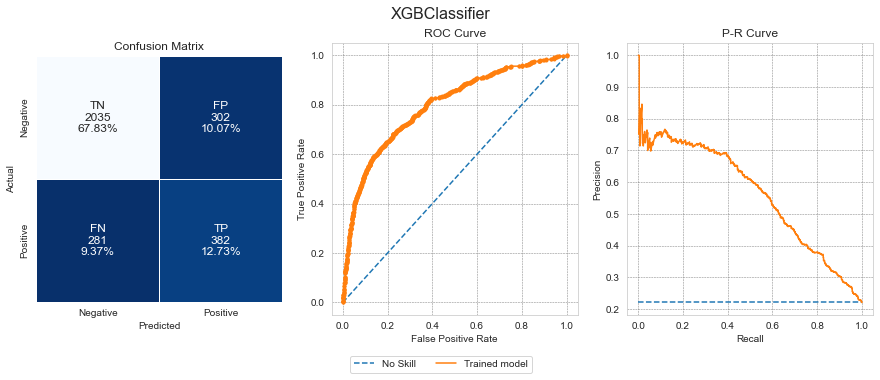

F1 Score: 0.5672
Recall: 0.5762
Precision: 0.5585
Specificity: 0.8708
ROC AUC Score: 0.7958753890944482
P-R AUC Score: 0.5612113429517127


In [52]:
model_performance_check(pipe_copy, X_val, y_val)

## Feature importance

The best-rated model so far has been examined in terms of importance of its features. The **feature importance** shows how useful it was in creating the decision tree of the model. Since usability is calculated for each feature in the dataset, the values obtained by creating node points in the decision tree allow for proper ranking and comparison of all features in terms of their impact on the model construction.

The names of the features were distinguished, and then, on the basis of the `.feature_importance_` attribute contained in the XGBoost model, a DataFrame was created, which will be used for the visualization.

In [53]:
cat_names= pipe_copy['preprocessor'].named_transformers_['categorical'].get_feature_names_out()

feature_names = np.r_[num_features, cat_names, ord_features]
feature_importance_df = pd.DataFrame(data={'feature': feature_names, 
                                           'importance': pipe_copy['classifier'].feature_importances_
                                          }).sort_values(by='importance',ascending=False)
feature_importance_df['cumul_importance'] = np.cumsum(feature_importance_df.importance)
feature_importance_df.head(5)

,feature,importance,cumul_importance
2,pay_0,0.334455,0.334455
3,pay_2,0.166025,0.500480
4,pay_3,0.077669,0.578149
6,pay_5,0.054936,0.633086
7,pay_6,0.044740,0.677826


The charts below show the importance of a feature and its impact on the model, as well as the cumulative increase in importance, taking into account subsequent features.

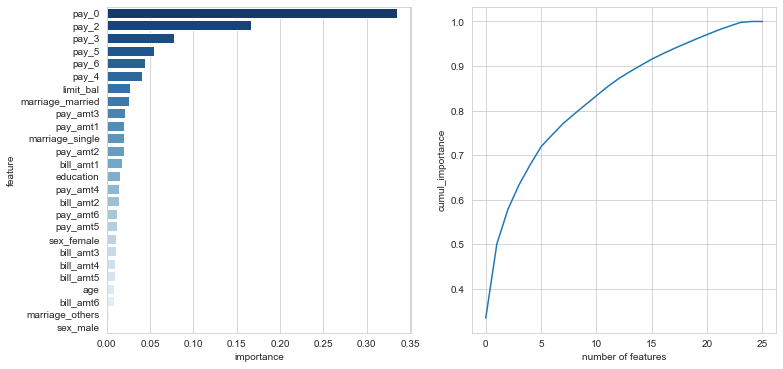

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(data=feature_importance_df.sort_values(by='importance', 
            ascending=False), y='feature', x='importance', orient = 'h', 
            palette='Blues_r', ax=axes[0])
plt.grid()
sns.lineplot(data=feature_importance_df, 
                    x=range(len(feature_names)), 
                    y=feature_importance_df['cumul_importance'], 
                    #ax=axes[1], lw=2).axhline(y = 0.95, color = 'g', lw=2, ls='--'
                    )
plt.xlabel("number of features")
plt.grid()


## Hyperparameters optimization - Bayesian approach 

A different optimization method will be used to further improve the performance of the selected model. With the Bayesian approach, the main assumption is that, unlike simple optimization techniques such as **Grid Search** as well as **Random Search** (which selects hyperparameters at random), the hyperparameter space is searched more well-thought-out, which is associated with a greater expenditure on the preparation process of this optimization technique, but with the benefit of reducing completely suboptimal choices and, as a result, greater computational efficiency.

The **Hyperopt** library will be used to perform this optimization method. The implementation will require the creation of an objective function, and then, using an appropriate algorithm: Tree-Structured Parzen Estimator (TPE), the best combination of arguments from the hyperparameter space will be selected by minimizing errors within the indicated number of iterations.

Below, the hyperparameter space for the selected model is defined and placed in the `space` dictionary:

In [55]:
space={'max_depth': hp.choice('max_depth', np.arange(2, 15, dtype=int)),
        'gamma': hp.uniform('gamma', 1,10),
        'subsample': hp.quniform ('subsample', 0.5, 1 , 0.1),
        'reg_alpha' : hp.uniform('reg_alpha', 0, 2),
        'reg_lambda' : hp.uniform('reg_lambda',0, 3), #1
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1), #1
        'min_child_weight' : hp.choice('min_child_weight', np.arange(0, 10, dtype=int)),
    }

The objective function was also created:

In [56]:
def objective(params):   
    
    pipe_params = {}
    space = params
    for s in space:
        pipe_params[f"classifier__{s}"] = space[s]
    
    pipe_copy.set_params(**pipe_params)
    
    score = cross_val_score(pipe_copy, X_train, y_train, 
                        cv=skfold, scoring=f1_scoring, error_score='raise')
    return -score.mean()

Then, using the `fmin` function from the **Hyperopt** library, a search for the combination of hyperparameters was started, minimizing the loss function:

In [57]:
%%time

MAX_EVALS = 50

trials = Trials()
best_params_bayes = fmin(fn= objective,
                space= space,
                algo= tpe.suggest,
                max_evals = MAX_EVALS,
                trials= trials)

100%|█████████████████████████████████████████████| 50/50 [1:08:54<00:00, 82.69s/trial, best loss: -0.5478663680448139]
Wall time: 1h 8min 54s


The data collected in the created `trials` object and sent to DataFrame allowed for the visualization of the process of minimizing the loss function during subsequent iterations:

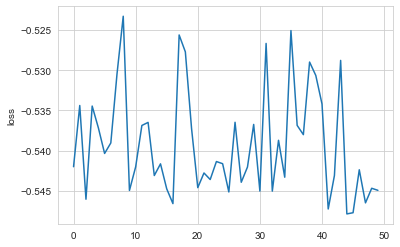

In [58]:
bayes_df = pd.DataFrame(trials.losses(), columns=['loss'])
sns.lineplot(data=bayes_df, x=bayes_df.index, y="loss")
plt.show()

This way, the best combination of hyparameters in the iteration was obtained and passed to the XGBoost model. The model was placed in the `pipe_final` object, which was then trained throughout cross-validation.

In [59]:
model_results_final = []

final_model = xgb.XGBClassifier(use_label_encoder=False, 
                                   **best_params_bayes, 
                                   verbosity=0 
                                   #learning_rate=0.05,
                                   #n_estimators=500
                               )

pipe_final = clone(pipe)
pipe_final.steps.append(['classifier', final_model])
pipe_final.fit(X_train, y_train)

cv_res_final = cross_val_score(pipe_final, X_train, y_train, cv=skfold, 
                                n_jobs=5, scoring=f1_scoring)


In [60]:
model_results_final_df = pd.DataFrame(cv_res_final, columns=['XGBoost'])
model_results_final_df.describe().transpose().round(4)

,count,mean,std,min,25%,50%,75%,max
XGBoost,10.0,0.5375,0.0257,0.5015,0.5246,0.5335,0.5509,0.5824


In [61]:
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['limit_bal', 'age', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
                                                   'pay_amt3', 'pay_amt4',
                                                   'pay_amt5', 'pay_amt6']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse=False),
                                                  ['sex'...
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=1, min_child_weight=9, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=1.83954695440194,
                               reg_lambda=1.1977620771915052,
                               scale_pos_weight=1, subsample=1.0,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=0)]])

The efficiency of the model was once again tested on validation data:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


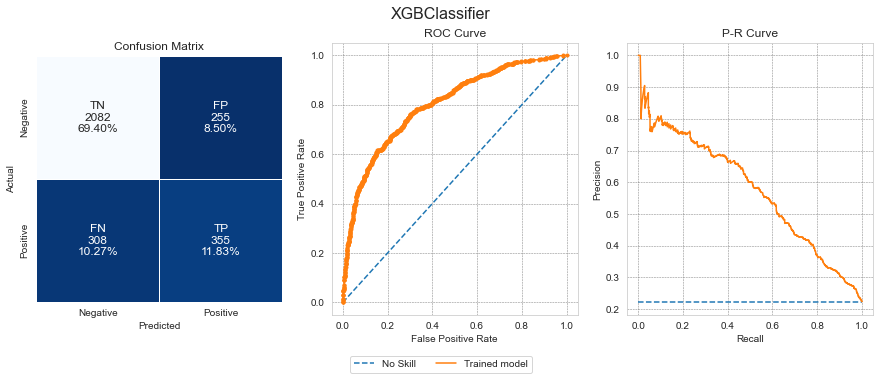

F1 Score: 0.5577
Recall: 0.5354
Precision: 0.5820
Specificity: 0.8909
ROC AUC Score: 0.8007510499015447
P-R AUC Score: 0.5747371458697376


In [62]:
model_performance_check(pipe_final, X_val, y_val)

# Final model evaluation on test data

Once went through the subsequent stages of model training, including initial data processing, undersampling, and then optimization using the Grid Search technique and Bayesian optimization method, a decision was made to finally check the model on test data.

As can be seen, the value of the Harmonic Precision-Recall Mean (F1) in the test data prediction turned out to be lower than F1 in the validation data.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


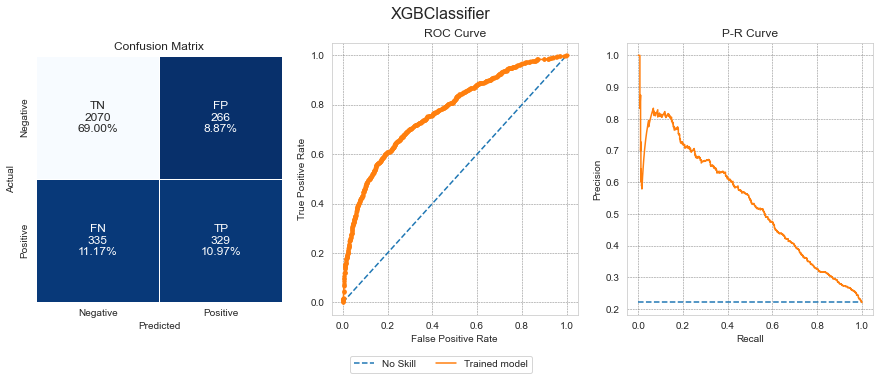

F1 Score: 0.5226
Recall: 0.4955
Precision: 0.5529
Specificity: 0.8861
ROC AUC Score: 0.7697665662650601
P-R AUC Score: 0.5352190605767823


In [63]:
model_performance_check(pipe_final, X_test, y_test)

# Conclusion

In this experiment, a number of sampling tools and optimization techniques were used, which allowed for a relatively small increase in the average prediction score of the F1 model from 0.47 to F1 at the level of 0.55 for training data. The final prediction score for the validation data changed to 0.56, the prediction for the test data did not allow to obtain an equally high score.

The difference between the score of validation data and the test data may have arisen due to the random split of the data made at the beginning of the modeling and the determined proportion of these data, which is worth paying attention to when determining the percentage size of the splits during subsequent experiments.

In addition, due to the relative effectiveness of the undersampling technique used, it is worth considering the use of other sampling algorithms - also in combination with the Bayesian method of hyperparameter optimization.

Moreover, the used F1 metric has other variants which, when maximized in the model training process, may have an impact on the reduction of false negative predictions at the expense of false positive and vice versa, depending on the need to approach the problem.

As part of the assessment of the potential usefulness of the model to predict classes of new observations, using the above visualization of the P-R (Precision-Recall) curve on the graph, it can be assumed that the results achieved by the trained model seem to be significantly higher than the completely random model. This leads to the final conclusion that the implementation of such a classification model may ultimately depend on the potential costs of non-detection of a positive class and the costs of misclassification. In the case of the tested data set, the implementation of the model may, for example, be an additional indicator when planning to secure the liquidity of the lender.

# References:

Dataset:

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Books:

*   Bruce P., Bruce A., Geodeck P., *Practical Statistics for Data Scientists: 50+ Essential Concepts Using R and Python, 2nd Edition*, Helion 2021
*   Lewinson E., *Python for Finance Cookbook*, Packt Publishing 2020

Website materials:

*   https://seaborn.pydata.org/
*   https://matplotlib.org/stable/tutorials/index.html

*   https://en.wikipedia.org/wiki/Accuracy_paradox
*   https://www.statystyka.az.pl/test-anova-kruskala-wallisa.php
*   https://pingouin-stats.org/generated/pingouin.kruskal.html#pingouin.kruskal

*   https://scikit-learn.org/stable/index.html
*   https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/
*   https://imbalanced-learn.org/stable/

*   https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/
*   https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/
*   https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html

*   https://medium.datadriveninvestor.com/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f
*   https://lightgbm.readthedocs.io/en/latest/Parameters.html
*   https://xgboost.readthedocs.io/en/stable/parameter.html
*   https://blog.prokulski.science/2020/12/23/hyperopt-scikit-learn/
*   https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


